In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [12]:
directory = "./drawings/long/"
filename = "l_all_dft_reconstructed_500.csv"
df = pd.read_csv(directory + filename)
df.describe()

,x,y,dft_real,dft_imag
count,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5.380072,0.616869,-1.953993e-18,5.329071e-18
std,81.284273,79.230858,3.269075e+00,3.891160e+00
min,-336.000000,-308.903358,-7.690357e+01,-1.442880e+02
25%,-41.821308,-45.533518,-9.546627e-03,-1.029477e-02
50%,4.634599,1.145781,4.916455e-04,-8.252626e-05
75%,54.437622,48.445373,1.202501e-02,1.134822e-02
max,291.000000,275.000000,6.778684e+01,1.742583e+02


In [108]:
np.array([[1,2,3],
          [1,2,3]]).shape


(2, 3)

In [157]:
BATCH_SIZE = 2

data_real, data_imag = np.array(df["dft_real"]), np.array(df["dft_imag"])
data_real = np.reshape(data_real, (20,500)).T
data_imag = np.reshape(data_imag, (20,500)).T

data =  np.concatenate((data_real, data_imag))
data = data.T
print("Data shape: " + str(data.shape))

max_val = np.max(np.abs(data))
data = torch.tensor(data, dtype=torch.float32)

data = data / max_val

y_x, y_y = np.array(df['x']), np.array(df['y'])
y_x = np.reshape(y_x, (20,500))
y_y = np.reshape(y_y, (20,500))

y = np.stack((y_x, y_y), axis=2)

print("y shape: " + str(y.shape))

y = torch.tensor(y, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(data, y)

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

Data shape: (20, 1000)
y shape: (20, 500, 2)


In [158]:
print(len(dataset))          # should be 20
batch = next(iter(data_loader))
print(batch[0].shape)        # (2, 1000)

20
torch.Size([2, 1000])


In [159]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 1000
        self.encoder = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128,64),
        )
        
        # N, 32
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1000),
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [160]:
model = AutoencoderLinear()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay=1e-5)

In [161]:
def inverse_fourier_descriptor_transform(Z):
    N = Z.shape[0]
    z = torch.fft.ifft(Z * N)
    g_reconstructed = torch.stack((z.real, z.imag), dim=1)  # shape (N, 2)
    return g_reconstructed

# def dft2img(Z):
#     # N = len(dft)
#     # Z = dft[:N//2] + 1j * dft[N//2:]
#     recon = inverse_fourier_descriptor_transform(Z)

In [162]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    for dft, spiral in data_loader:
        recon = model(dft)  # shape (batch, N*2)
        N = recon.shape[1]
        spiral_recs = []

        # print(spiral.shape)
        # plt.plot(spiral[0])
        # plt.show()
        # break
        
        for i in range(BATCH_SIZE):
            recon_temp = recon[i] * max_val
            Z_temp = recon_temp[:N//2] + 1j * recon_temp[N//2:]   # create complex tensor
            Z_temp = Z_temp.type(torch.complex64)  # ensure complex type
            rec_temp = inverse_fourier_descriptor_transform(Z_temp)
            spiral_recs.append(rec_temp)

        spiral_recs = torch.stack(spiral_recs)  # shape (batch, N, 2)
        loss = criterion(spiral_recs, spiral)    # now gradients work
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, spiral, spiral_recs))

Epoch:1, Loss:10289.3428
Epoch:2, Loss:9659.0332
Epoch:3, Loss:7863.8335
Epoch:4, Loss:29020.6367
Epoch:5, Loss:7979.4575
Epoch:6, Loss:6443.4214
Epoch:7, Loss:5979.9473
Epoch:8, Loss:28320.7559
Epoch:9, Loss:18386.3242
Epoch:10, Loss:18438.5273


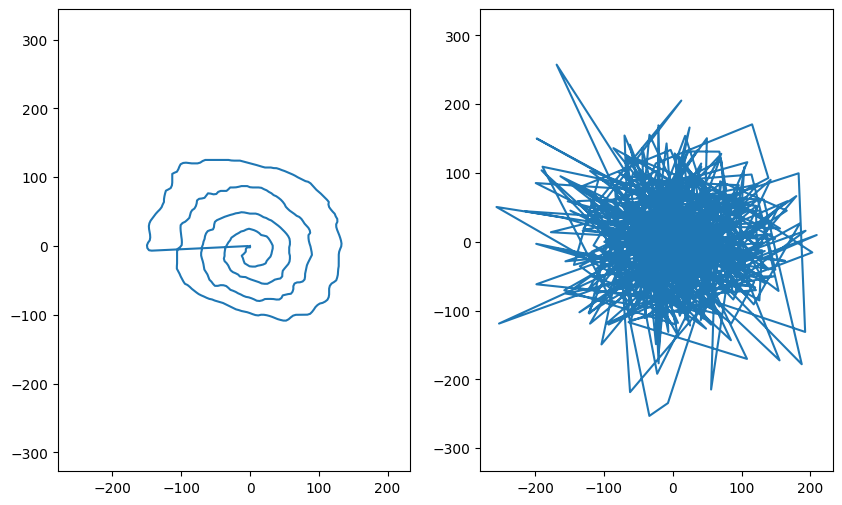

In [163]:
idx = 1
fig, axes = plt.subplots(1, 2, figsize=(10, 3 * 2), sharex=True)
x_plot = [xp for (xp,yp) in outputs[idx][1][0].detach().numpy()]
y_plot = [yp for (xp,yp) in outputs[idx][1][0].detach().numpy()]
axes[0].plot(x_plot, y_plot)
axes[0].axis('equal')

x_plot = [xp for (xp,yp) in outputs[idx][2][0].detach().numpy()]
y_plot = [yp for (xp,yp) in outputs[idx][2][0].detach().numpy()]
axes[1].plot(x_plot, y_plot)
axes[1].axis('equal')

plt.show()

In [26]:
for X in data_loader:
    print(X.shape)
    break

torch.Size([1, 20, 1000])
